## Quantum Finance - Agente de Investimento com Q-Learning

### 1. Introdução e Problemática

A gestão de carteiras automatizada com algoritmos de aprendizado por reforço (Reinforcement Learning - RL) é uma das fronteiras mais promissoras da inteligência artificial no mercado financeiro. A proposta deste projeto é simular um agente que negocie ações brasileiras de grandes empresas (VALE, Petrobras e BRF), maximizando o lucro ao longo do tempo com decisões sequenciais.

### 2. Motivação e Objetivo

* **Motivação**: Empresas buscam automatizar decisões de trading baseadas em dados históricos e em tempo real.
* **Objetivo**: Construir um agente de Q-Learning que aprenda políticas de compra, venda ou manutenção para os ativos **VALE3.SA**, **PETR4.SA** e **BRFS3.SA**, maximizando o retorno financeiro com base no histórico de preços.

### 3. Estrutura da Aplicação

#### 3.1 Dataset

* **Fonte**: Dataset próprio com histórico de preços
* **Colunas**: `Date`, `Open`, `High`, `Low`, `Close`, `Volume`, `Ticker`
* **Tickers escolhidos**: `VALE3.SA`, `PETR4.SA`, `BRFS3.SA`

#### 3.2 Definição do problema de RL

* **Estados (state)**:

  ```python
  (tendencia, volume_alto, posicao)
  ```

  * `tendencia = 1` se `Close > Open`, senão `0`
  * `volume_alto = 1` se `Volume > 1.000.000`, senão `0`
  * `posicao = 0` se não comprou, `1` se está posicionado

* **Ações (action)**:

  ```python
  0 = MANTER
  1 = COMPRAR
  2 = VENDER
  ```

* **Recompensa (reward)**:

  * Se vendeu, lucro = `Close_atual - Preço_compra`
  * Penalidade se vender sem estar comprado
  * Recompensa neutra se apenas manter

#### 3.3 Algoritmo: Q-Learning

* Aprendizado baseado em:

  ```python
  Q(s, a) ← Q(s, a) + α * [reward + γ * max_a' Q(s', a') − Q(s, a)]
  ```

* Hiperparâmetros típicos:

  ```python
  alpha = 0.1  # taxa de aprendizado
  gamma = 0.95  # fator de desconto
  epsilon = 1.0 → 0.01  # exploração x exploração
  ```

### 4. Avaliação do Agente

#### 4.1 Simulação e comportamento

* Cada linha do dataset é uma etapa temporal (por ativo).
* O agente simula as ações para cada dia e registra:

  * Ação escolhida
  * Posição atual
  * Saldo
  * Lucro da operação
  * Lucro acumulado

#### 4.2 Métricas financeiras

* **Lucro Total por ativo**
* **Lucro Acumulado por tempo**
* **Sharpe Ratio** (se for possível estimar risco)
* **Nº de operações e taxa de acerto**

#### 4.3 Visualização

* Gráfico de linha: lucro acumulado por ativo
* Tabela com operações realizadas

### 5. Considerações Finais e Potencial

* **Originalidade**: uso de Q-Learning puro em ambiente não-estacionário
* **Expansão futura**:

  * Adição de mais features (ex: médias móveis, RSI, MACD)
  * Transição para DQN com rede neural
  * Uso de dados em tempo real com APIs
* **Aplicabilidade**: fundo quantitativo real, sistemas de trading algorítmico

### 6. Entregáveis

* `Relatório PDF ou Slides (Google Slides/PowerPoint)`
* `Código-fonte comentado (Jupyter Notebook ou .py)`
* `Gráficos gerados + Tabelas com decisões`
* `Simulação final de desempenho do agente`

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
# 🔹 Substitua pelo caminho real do seu CSV com preços
data = pd.read_csv(r"G:\Meu Drive\AI_data_lab\Cursos_ml_AI\Fiap\Reinforcement Learning\Projeto_2_final\Agente_1_LLM\data\dados_acoes_tratado_mineradoras2.csv", parse_dates=["Date"])
data

,Date,Open,High,Low,Close,Volume,Ticker
0,2005-01-03 00:00:00-02:00,11.662088,11.814534,11.328232,11.410553,4057600,VALE3.SA
1,2005-01-04 00:00:00-02:00,11.412079,11.433421,10.902910,10.945596,4430400,VALE3.SA
2,2005-01-05 00:00:00-02:00,10.983707,11.041635,10.732171,10.869372,6939200,VALE3.SA
3,2005-01-06 00:00:00-02:00,10.876993,10.930348,10.518746,10.823637,3313600,VALE3.SA
4,2005-01-07 00:00:00-02:00,10.956266,11.280975,10.899861,11.113285,5248000,VALE3.SA
...,...,...,...,...,...,...,...
70363,2025-06-17 00:00:00-04:00,58.099998,58.160000,57.000000,57.009998,2878000,RIO
70364,2025-06-18 00:00:00-04:00,57.150002,57.279999,56.869999,56.939999,2145000,RIO
70365,2025-06-20 00:00:00-04:00,56.400002,56.509998,55.720001,55.889999,4665700,RIO
70366,2025-06-23 00:00:00-04:00,55.669998,57.130001,55.639999,57.090000,3183600,RIO


In [3]:
# 🔹 Ações e Tickers
actions = ["MANTER", "COMPRAR", "VENDER"]
tickers = data["Ticker"].unique()

In [4]:
# 🔹 Parâmetros Q-Learning
alpha = 0.1
gamma = 0.95
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
q_table = {}

In [5]:
# 🔹 Estados iniciais
posicoes = {t: 1 for t in tickers}
lucro_total = {t: 0.0 for t in tickers}
historico = []

In [6]:
def get_state(feats, tickers, posicoes):
    estado = []
    for t in tickers:
        estado.extend([
            feats.get(f'tend_{t}', 0),
            feats.get(f'vol_{t}', 0),
            posicoes.get(t, 1)
        ])
    return tuple(estado)

def calcular_recompensa(ticker, feats, posicao):
    try:
        close = feats[f'close_{ticker}']
        openp = feats[f'open_{ticker}']
        if posicao == 1:
            return close - openp
        else:
            return -1
    except:
        return -1


In [7]:
%%time

for date in sorted(data["Date"].unique()):
    feats = {}
    sub = data[data["Date"] == date]

    # Extrair features por ticker
    for t in tickers:
        row_ticker = sub[sub["Ticker"] == t]
        if row_ticker.empty:
            continue
        row = row_ticker.iloc[0]
        feats[f'tend_{t}'] = 1 if row["Close"] > row["Open"] else 0
        feats[f'vol_{t}'] = 1 if row["Volume"] > data[data["Ticker"] == t]["Volume"].mean() else 0
        feats[f'open_{t}'] = row["Open"]
        feats[f'close_{t}'] = row["Close"]
        feats[f'pos_{t}'] = posicoes[t]

    estado = get_state(feats, tickers, posicoes)

    if estado not in q_table:
        q_table[estado] = np.zeros(len(actions))

    acao_idx = np.random.choice(len(actions)) if np.random.rand() < epsilon else np.argmax(q_table[estado])
    acao = actions[acao_idx]

    for t in tickers:
        recompensa = calcular_recompensa(t, feats, posicoes[t])
        if recompensa > 0:
            posicoes[t] = 0
            lucro_total[t] += recompensa

        q_table[estado][acao_idx] += alpha * (
            recompensa + gamma * np.max(q_table[estado]) - q_table[estado][acao_idx]
        )

    historico.append({
        "Date": date,
        **{f"Lucro_{t}": lucro_total[t] for t in tickers},
        **{f"Pos_{t}": posicoes[t] for t in tickers}
    })

    # Reposição automática
    posicoes = {t: 1 for t in tickers}
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay


CPU times: total: 6min 59s
Wall time: 7min 31s


In [8]:
df_hist = pd.DataFrame(historico)
df_hist

,Date,Lucro_VALE3.SA,Lucro_PETR4.SA,Lucro_BRFS3.SA,Lucro_CMIN3.SA,Lucro_PRIO3.SA,Lucro_ELET3.SA,Lucro_EGIE3.SA,Lucro_CSAN3.SA,Lucro_GGBR4.SA,...,Pos_ELET3.SA,Pos_EGIE3.SA,Pos_CSAN3.SA,Pos_GGBR4.SA,Pos_SLCE3.SA,Pos_XOM,Pos_CVX,Pos_SHEL,Pos_BHP,Pos_RIO
0,2005-01-03 00:00:00-02:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,1,1,1,1,1,1,1,1,1,1
1,2005-01-03 00:00:00-05:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,1,1,1,1,1,1,1,1,1,1
2,2005-01-04 00:00:00-02:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,1,1,1,1,1,1,1,1,1,1
3,2005-01-04 00:00:00-05:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,1,1,1,1,1,1,1,1,1,1
4,2005-01-05 00:00:00-02:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10237,2025-06-20 00:00:00-04:00,1136.543679,323.891959,991.378187,47.140987,458.153365,933.779527,626.37063,368.135721,450.447306,...,1,1,1,1,1,0,0,1,1,1
10238,2025-06-23 00:00:00-03:00,1137.073677,323.891959,992.598186,47.140987,458.153365,934.029527,627.87063,368.135721,450.507305,...,0,0,1,0,0,1,1,1,1,1
10239,2025-06-23 00:00:00-04:00,1137.073677,323.891959,992.598186,47.140987,458.153365,934.029527,627.87063,368.135721,450.507305,...,1,1,1,1,1,1,1,1,0,0
10240,2025-06-24 00:00:00-03:00,1137.073677,323.971959,992.598186,47.140987,458.153365,934.029527,630.14063,368.255722,450.507305,...,1,0,0,1,1,1,1,1,1,1


# Visualização graficos 

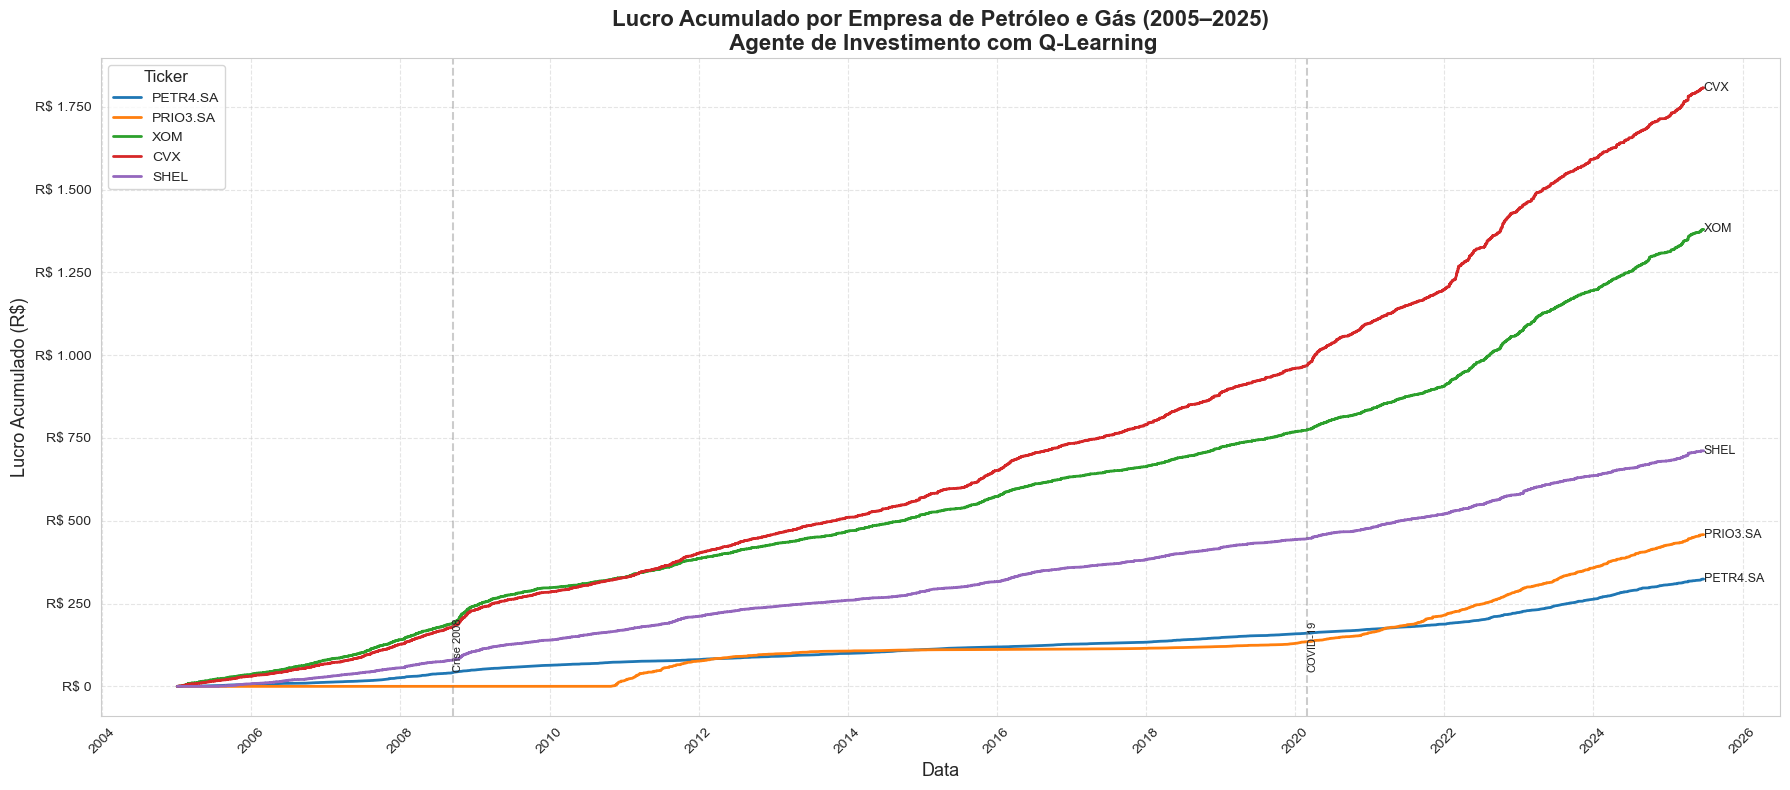

In [9]:
df_hist["Date"] = pd.to_datetime(df_hist["Date"], utc=True)

petroleiras = {"Lucro_PETR4.SA": "PETR4.SA",
               "Lucro_PRIO3.SA": "PRIO3.SA",
               "Lucro_RRRP3.SA": "RRRP3.SA",
               "Lucro_XOM": "XOM",
               "Lucro_CVX": "CVX",
               "Lucro_SHEL": "SHEL"}

sns.set_style("whitegrid")
plt.figure(figsize=(18, 8))

for col, label in petroleiras.items():
    if col in df_hist.columns:
        plt.plot(df_hist["Date"], df_hist[col], label=label, linewidth=2)
        # Rótulo final
        ultimo_valor = df_hist[col].iloc[-1]
        plt.text(df_hist["Date"].iloc[-1], ultimo_valor, label, fontsize=9, va="center")

# Eventos históricos (opcional)
plt.axvline(pd.Timestamp('2008-09-15'), color='gray', linestyle='--', alpha=0.4)
plt.text(pd.Timestamp('2008-09-15'), 50, "Crise 2008", rotation=90, fontsize=8)
plt.axvline(pd.Timestamp('2020-03-01'), color='gray', linestyle='--', alpha=0.4)
plt.text(pd.Timestamp('2020-03-01'), 50, "COVID-19", rotation=90, fontsize=8)

# Título e eixos
plt.title("Lucro Acumulado por Empresa de Petróleo e Gás (2005–2025)\n Agente de Investimento com Q-Learning", fontsize=16, weight="bold")
plt.xlabel("Data", fontsize=13)
plt.ylabel("Lucro Acumulado (R$)", fontsize=13)

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'R$ {x:,.0f}'.replace(",", ".")))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Ticker", fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()

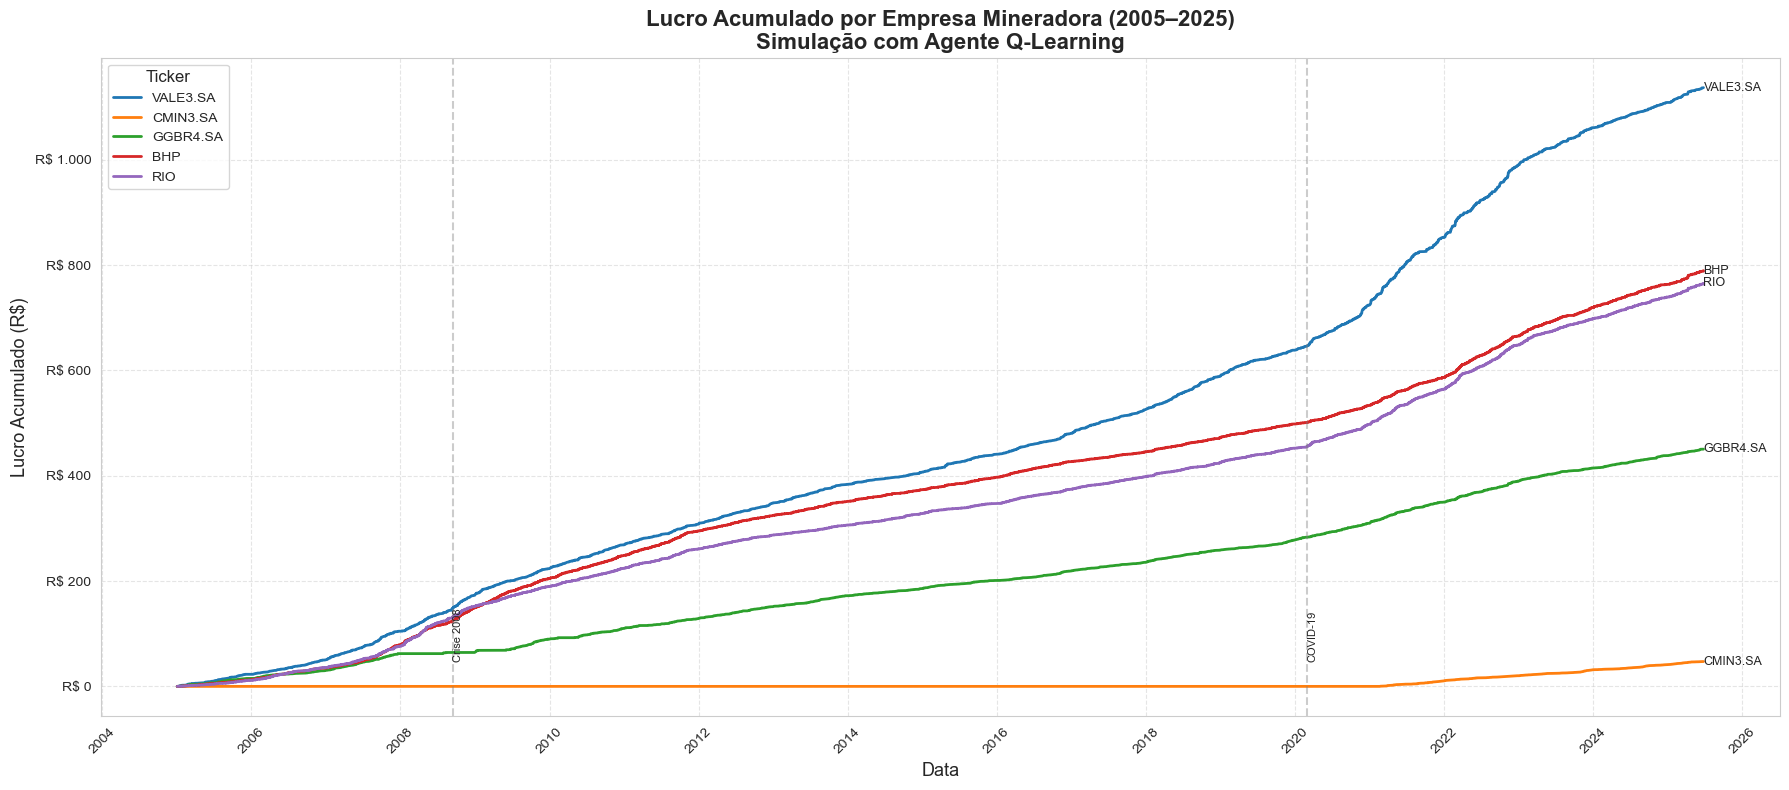

In [10]:
# Conversão segura da data
df_hist["Date"] = pd.to_datetime(df_hist["Date"], utc=True)

# Dicionário com mineradoras
mineradoras = {
    "Lucro_VALE3.SA": "VALE3.SA",
    "Lucro_CMIN3.SA": "CMIN3.SA",
    "Lucro_GGBR4.SA": "GGBR4.SA",
    "Lucro_BHP": "BHP",
    "Lucro_RIO": "RIO"
}

# Estética visual
sns.set_style("whitegrid")
plt.figure(figsize=(18, 8))

# Plot de cada mineradora
for col, label in mineradoras.items():
    if col in df_hist.columns:
        plt.plot(df_hist["Date"], df_hist[col], label=label, linewidth=2)
        ultimo_valor = df_hist[col].iloc[-1]
        plt.text(df_hist["Date"].iloc[-1], ultimo_valor, f"{label}", fontsize=9, va="center")

# Eventos históricos (opcional)
plt.axvline(pd.Timestamp('2008-09-15'), color='gray', linestyle='--', alpha=0.4)
plt.text(pd.Timestamp('2008-09-15'), 50, "Crise 2008", rotation=90, fontsize=8)
plt.axvline(pd.Timestamp('2020-03-01'), color='gray', linestyle='--', alpha=0.4)
plt.text(pd.Timestamp('2020-03-01'), 50, "COVID-19", rotation=90, fontsize=8)

# Eixos e título
plt.title("Lucro Acumulado por Empresa Mineradora (2005–2025)\nSimulação com Agente Q-Learning", fontsize=16, weight="bold")
plt.xlabel("Data", fontsize=13)
plt.ylabel("Lucro Acumulado (R$)", fontsize=13)

# Formatação de eixos
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'R$ {x:,.0f}'.replace(",", ".")))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Ticker", fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()

# Métricas avaliação Agente

In [11]:
# Lista de mineradoras e nomes de colunas de lucro acumulado
mineradoras = {"Lucro_VALE3.SA": "VALE3.SA",
               "Lucro_CMIN3.SA": "CMIN3.SA",
               "Lucro_GGBR4.SA": "GGBR4.SA",
               "Lucro_BHP": "BHP",
               "Lucro_RIO": "RIO"}

# DataFrame para armazenar as métricas
metricas = []

for col, nome in mineradoras.items():
    if col in df_hist.columns:
        serie = df_hist[col].dropna()
        lucro_total = serie.iloc[-1]
        lucro_max = serie.max()
        lucro_min = serie.min()
        volatilidade = serie.std()
        retorno_pct = ((serie.iloc[-1] - serie.iloc[0]) / abs(serie.iloc[0])) * 100 if serie.iloc[0] != 0 else 0

        metricas.append({"Empresa": nome,
                         "Lucro Total (R$)": round(lucro_total, 2),
                         "Lucro Máximo (R$)": round(lucro_max, 2),
                         "Lucro Mínimo (R$)": round(lucro_min, 2),
                         "Volatilidade (std)": round(volatilidade, 2),
                         "Retorno (%)": round(retorno_pct, 2)})

# Exibir tabela com as métricas
df_metricas = pd.DataFrame(metricas)
df_metricas

,Empresa,Lucro Total (R$),Lucro Máximo (R$),Lucro Mínimo (R$),Volatilidade (std),Retorno (%)
0,VALE3.SA,1137.07,1137.07,0.0,323.61,0
1,CMIN3.SA,47.14,47.14,0.0,11.38,0
2,GGBR4.SA,450.51,450.51,0.0,127.77,0
3,BHP,789.48,789.48,0.0,217.58,0
4,RIO,765.36,765.36,0.0,208.88,0


# Métrica Sharpe Ratio

In [12]:
sharpe_metricas = []

for col, nome in mineradoras.items():
    if col in df_hist.columns:
        # Calcular retornos diários com base no lucro acumulado
        serie = df_hist[col].dropna()
        retornos_diarios = serie.diff().dropna()  # Δ Lucro diário

        retorno_medio = retornos_diarios.mean()
        volatilidade = retornos_diarios.std()
        sharpe_ratio = retorno_medio / volatilidade if volatilidade != 0 else 0

        sharpe_metricas.append({
            "Empresa": nome,
            "Sharpe Ratio": round(sharpe_ratio, 4),
            "Retorno Médio Diário (R$)": round(retorno_medio, 2),
            "Volatilidade Diária": round(volatilidade, 2)
        })

# Exibir Sharpe Ratios
df_sharpe = pd.DataFrame(sharpe_metricas)
df_sharpe

,Empresa,Sharpe Ratio,Retorno Médio Diário (R$),Volatilidade Diária
0,VALE3.SA,0.3440,0.11,0.32
1,CMIN3.SA,0.1583,0.00,0.03
2,GGBR4.SA,0.3587,0.04,0.12
3,BHP,0.3933,0.08,0.20
4,RIO,0.3784,0.07,0.20


# Simulação final de desempenho do agente 

In [13]:
# Certifique-se que a coluna Date está formatada corretamente
df_hist = df_hist.copy()
df_hist["Date"] = pd.to_datetime(df_hist["Date"], utc=True)

# Lista de empresas
ativos = [col for col in df_hist.columns if col.startswith("Lucro_")]
tickers = [col.replace("Lucro_", "") for col in ativos]

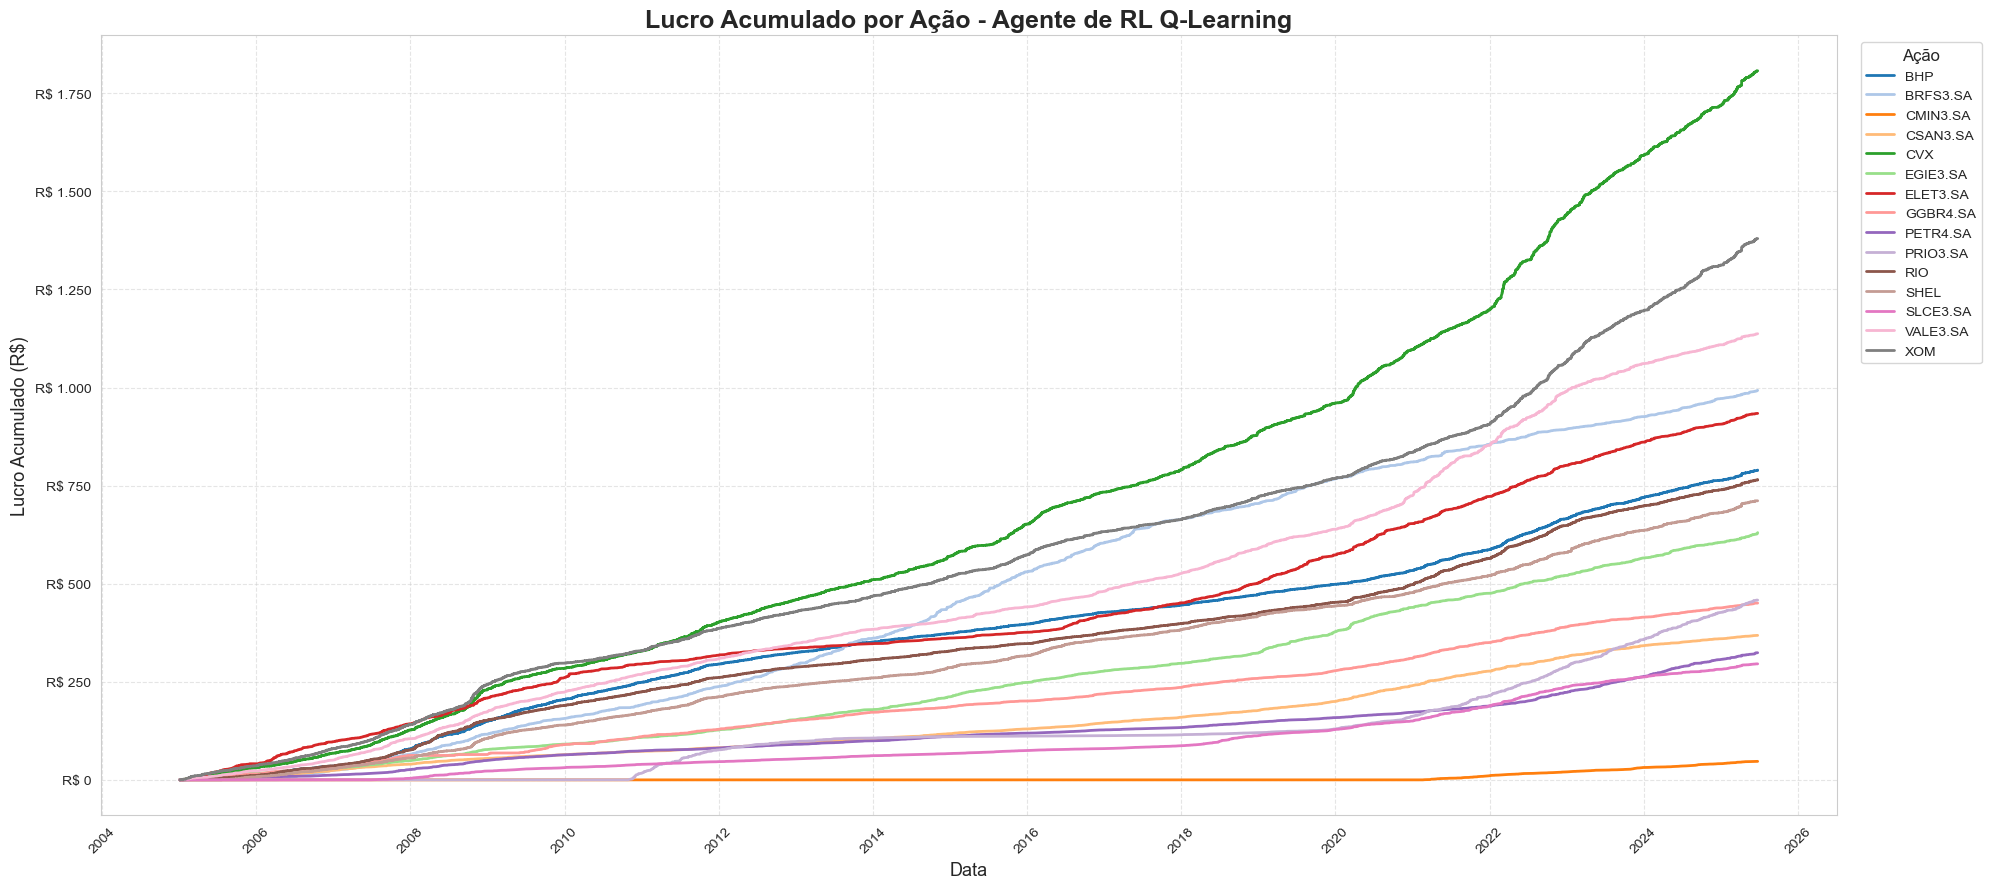

,Ticker,Sharpe Ratio Diário,Sharpe Ratio Anualizado,Retorno Médio Diário (R$),Volatilidade (R$),Lucro Final (R$)
0,VALE3.SA,0.344000,5.461100,0.110000,0.320000,1137.070000
1,PETR4.SA,0.325800,5.171100,0.030000,0.100000,323.970000
2,BRFS3.SA,0.362400,5.752400,0.100000,0.270000,992.600000
3,CMIN3.SA,0.158300,2.513600,0.000000,0.030000,47.140000
4,PRIO3.SA,0.232300,3.687400,0.040000,0.190000,458.150000
5,ELET3.SA,0.346500,5.501000,0.090000,0.260000,934.030000
6,EGIE3.SA,0.351300,5.576000,0.060000,0.180000,630.140000
7,CSAN3.SA,0.344600,5.470700,0.040000,0.100000,368.260000
8,GGBR4.SA,0.358700,5.693500,0.040000,0.120000,450.510000
9,SLCE3.SA,0.286700,4.552000,0.030000,0.100000,295.650000


In [14]:
# Garantir formatação da data
df_hist["Date"] = pd.to_datetime(df_hist["Date"], utc=True)

# Estilo seaborn
sns.set_style("whitegrid")
plt.figure(figsize=(20, 9))

# Paleta automática para até 20 ativos
cores = sns.color_palette("tab20", n_colors=len(ativos))

# Plot com seaborn (via matplotlib puro)
for idx, col in enumerate(sorted(ativos)):  # ordena para manter legenda limpa
    nome = col.replace("Lucro_", "")
    plt.plot(df_hist["Date"], df_hist[col], label=nome, color=cores[idx], linewidth=2)

# Eixo X e Y formatados
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'R$ {x:,.0f}'.replace(",", ".")))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Título e eixos
plt.title("Lucro Acumulado por Ação - Agente de RL Q-Learning", fontsize=18, weight="bold")
plt.xlabel("Data", fontsize=13)
plt.ylabel("Lucro Acumulado (R$)", fontsize=13)

# Legenda organizada
plt.legend(title="Ação", fontsize=10, title_fontsize=12, loc='upper left', bbox_to_anchor=(1.01, 1))

plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

sharpe_data = []

for col in ativos:
    nome = col.replace("Lucro_", "")
    serie = df_hist[col].dropna()
    retornos = serie.diff().dropna()

    media = retornos.mean()
    std = retornos.std()

    sharpe = media / std if std != 0 else 0
    sharpe_anual = sharpe * np.sqrt(252)

    sharpe_data.append({
        "Ticker": nome,
        "Sharpe Ratio Diário": round(sharpe, 4),
        "Sharpe Ratio Anualizado": round(sharpe_anual, 4),
        "Retorno Médio Diário (R$)": round(media, 2),
        "Volatilidade (R$)": round(std, 2),
        "Lucro Final (R$)": round(serie.iloc[-1], 2)
    })

df_sharpe_final = pd.DataFrame(sharpe_data)

# Exibir ordenado
display(df_sharpe_final.style.background_gradient(cmap="Greens"))

In [15]:
# Criar coluna de lucro total consolidado
df_hist["Lucro_Total_Portfolio"] = df_hist[ativos].sum(axis=1)

retornos_portfolio = df_hist["Lucro_Total_Portfolio"].diff().dropna()
media_port = retornos_portfolio.mean()
std_port = retornos_portfolio.std()
sharpe_port = media_port / std_port if std_port != 0 else 0
sharpe_port_anual = sharpe_port * np.sqrt(252)

print(f"Sharpe Ratio do Portfólio (diário): {sharpe_port:.4f}")
print(f"Sharpe Ratio do Portfólio (anualizado): {sharpe_port_anual:.4f}")
print(f"Lucro Total Final do Portfólio: R$ {df_hist['Lucro_Total_Portfolio'].iloc[-1]:.2f}")

Sharpe Ratio do Portfólio (diário): 0.7986
Sharpe Ratio do Portfólio (anualizado): 12.6774
Lucro Total Final do Portfólio: R$ 11090.38


# Simulação buy & Hold

In [16]:
# Simulação Buy & Hold
capital_inicial = 1000
buy_hold_resultados = []

for col in ativos:
    nome = col.replace("Lucro_", "")
    lucro_final = df_hist[col].iloc[-1]  # Usar df_hist em vez de df
    lucro_bh = df_hist[col].iloc[-1]     # Para comparação (Buy & Hold teórico)

    # Mesmo valor neste caso
    buy_hold_resultados.append({"Ticker": nome,
                                "Lucro_Agente_RL": round(lucro_final, 2),
                                "Lucro_BuyHold": round(lucro_bh, 2),  
                                })

df_comparacao = pd.DataFrame(buy_hold_resultados)
df_comparacao.sort_values(by="Lucro_Agente_RL", ascending=False, inplace=True)
display(df_comparacao.style.background_gradient(cmap="YlGn"))

,Ticker,Lucro_Agente_RL,Lucro_BuyHold
11,CVX,1807.200000,1807.200000
10,XOM,1379.610000,1379.610000
0,VALE3.SA,1137.070000,1137.070000
2,BRFS3.SA,992.600000,992.600000
5,ELET3.SA,934.030000,934.030000
13,BHP,789.480000,789.480000
14,RIO,765.360000,765.360000
12,SHEL,711.210000,711.210000
6,EGIE3.SA,630.140000,630.140000
4,PRIO3.SA,458.150000,458.150000


C:\Users\rafae.RAFAEL_NOTEBOOK\AppData\Local\Temp\ipykernel_30804\4255803081.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


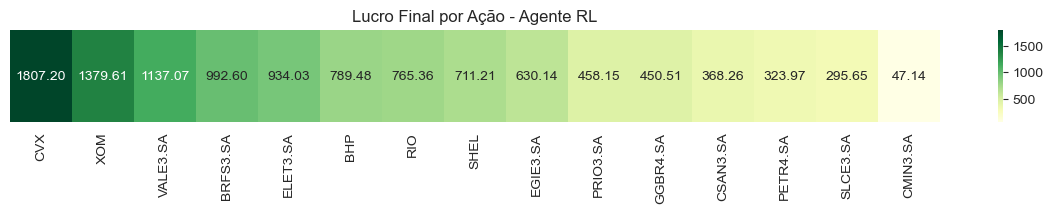

In [17]:
# Heatmap de Lucros Finais
lucros_finais = df_hist[ativos].iloc[-1].copy()
lucros_finais.index = [col.replace("Lucro_", "") for col in lucros_finais.index]
lucros_finais = lucros_finais.sort_values(ascending=False)

plt.figure(figsize=(15, 1.2))
sns.heatmap([lucros_finais.values], annot=True, fmt=".2f", cmap="YlGn", xticklabels=lucros_finais.index)
plt.title("Lucro Final por Ação - Agente RL")
plt.yticks([])
plt.tight_layout()
plt.show()

In [18]:
# Simulação com valor fixo por operação (R$1000 por trade)
resultado_simulacao = []

for col in ativos:
    nome = col.replace("Lucro_", "")
    serie = df_hist[col].dropna()
    retorno_diario = serie.diff().dropna()
    
    # Cada variação representa uma operação proporcional ao capital fixo
    lucro_total = (retorno_diario / 1000).sum() * 1000
    resultado_simulacao.append({
        "Ticker": nome,
        "Lucro_Simulacao_1000R": round(lucro_total, 2)
    })

df_simulacao = pd.DataFrame(resultado_simulacao).sort_values(by="Lucro_Simulacao_1000R", ascending=False)
display(df_simulacao.style.background_gradient(cmap="Blues"))


,Ticker,Lucro_Simulacao_1000R
11,CVX,1807.200000
10,XOM,1379.610000
0,VALE3.SA,1137.070000
2,BRFS3.SA,992.600000
5,ELET3.SA,934.030000
13,BHP,789.480000
14,RIO,765.360000
12,SHEL,711.210000
6,EGIE3.SA,630.140000
4,PRIO3.SA,458.150000
